In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import transforms         # 이미지 변형
from torch.utils.data.dataloader import DataLoader  # train - test 분리

from tensorboardX import SummaryWriter
writer = SummaryWriter()

## 데이터 불러오기

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.5),(1.0)) # 평균, 표준편차
])

train_data = MNIST(root='./', train=True, download=True, transform=data_transform) 
test_data = MNIST(root='./', train=False, download=True, transform=data_transform) 
# transform : 데이터 전처리함수

In [17]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [18]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=32) 

In [19]:
data, label = next(iter(train_loader))
print(data.shape)

torch.Size([32, 1, 32, 32])


## 모델 만들기

In [ ]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet, self).__init__()

        # convolutions
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)

        # fully connection
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        x = self.conv1(x)         
        x = F.tanh(x)             # 6 28 28
        x = F.max_pool2d(x, 2, 2) # subsampling 6 14 14

        x = self.conv2(x)         # 16 10 10 ((14 - 5 + (2 * 0)) / 1 + 1)
        x = F.tanh(x)
        x = F.max_pool2d(x, 2, 2) # 16 5 5

        x = self.conv3(x)         # 120 1 1 ((5 - 5 + (2 * 0)) / 1 + 1)
        x = F.tanh(x)

        x = x.view(-1, 120)         # 120

        x = self.fc1(x)             # 84
        x = F.tanh(x)

        x = self.fc2(x)             # 10
        x = F.tanh(x)

        return x

model = Lenet()

In [29]:
from torchsummary import summary

summary(model, input_size=(1, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            2,416
├─Conv2d: 1-3                            48,120
├─Linear: 1-4                            10,164
├─Linear: 1-5                            850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            2,416
├─Conv2d: 1-3                            48,120
├─Linear: 1-4                            10,164
├─Linear: 1-5                            850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0

In [ ]:
# 모두 gpu에 올라가게 하는 코드

# if torch.backends.cuda.is_available():
#   torch.set_default_device("cuda")

In [33]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epochs = 10
criterion = nn.CrossEntropyLoss()

step = 0
for epoch in range(epochs):
    for data, label in train_loader: # [(data, label)]
        optim.zero_grad() # 최적화 함수를 초기화 해야함 (한 번 학습시 마다)

        # 모델 학습
        pred = model(data.to(device)) # 데이터 위치 체크

        # 손실 계산
        loss = criterion(pred, label.to(device)) # 데이터 위치 체크

        # tensorboard에 데이터 추가
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1

        # 역전파
        loss.backward()
        optim.step()

    print(f"{epoch + 1} loss : {loss.item()}")

import joblib

# 모델 저장
joblib.dump(model, 'models/number_image_cnn_model.pkl')

1 loss : 0.8565922975540161
2 loss : 0.7982338666915894
3 loss : 0.8077666759490967
4 loss : 0.8249301910400391
5 loss : 0.8271752595901489
6 loss : 0.801733136177063
7 loss : 0.829251229763031
8 loss : 0.8053441047668457
9 loss : 0.8647257089614868
10 loss : 0.8069360256195068


['models/number_image_cnn_model.pkl']

## 모델 평가

In [50]:
# 모델 불러오기
loaded_model = joblib.load('models/number_image_cnn_model.pkl')

loaded_model.eval() # 모델을 추론용으로 전환하게 하는 코드

falut_data = []

with torch.no_grad():
    total_corr = 0
    for images, labels in test_loader:
        X = images.to(device)
        labels = labels.to(device)

        preds = loaded_model(X)
        _, pred = torch.max(preds.data, dim = 1)
        
        result = (pred == labels)
        total_corr += (result).sum().item()

        for i, re in enumerate(result):
            if re == False:
                falut_data.append({
                    'image' : images[i],
                    'pred' : pred[i],
                    'label' :labels[i]
                })

print(f'정확도 : {total_corr / len(test_data.targets)}')

정확도 : 0.9861


## 모델 사용

PIL Image 크기: (265, 257)
PIL Image 모드: RGB


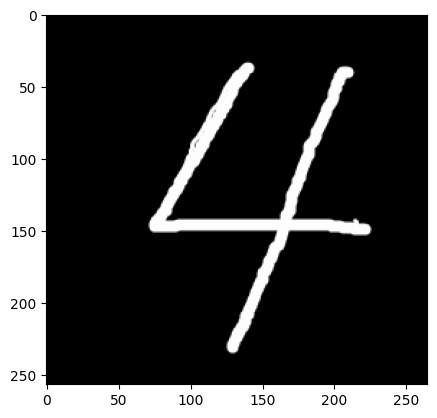


이미지를 텐서로 변환 완료:
텐서 크기(shape): torch.Size([1, 32, 32])
텐서 데이터 타입: torch.float32
예측 결과: 4


In [ ]:
from torchvision import transforms
from PIL import Image

# 1. 이미지 파일 경로 지정
image_path = 'images/4.jpg'

# 2. 이미지 변환(transform) 파이프라인 정의
# PyTorch 모델에 입력하기 위해 이미지를 텐서로 변환하는 과정을 정의
# ToTensor()는 PIL Image를 PyTorch 텐서로 변환하며, 픽셀 값을 [0, 1] 범위로 정규화
transform = transforms.Compose([
    transforms.ToTensor(),              # 이미지를 PyTorch 텐서로 변환
    transforms.Resize((32, 32)),        # 이미지를  리사이즈
    transforms.Normalize((0.5),(1.0))   # 평균, 표준편차
])

with Image.open(image_path) as image:
        print(f"PIL Image 크기: {image.size}")
        print(f"PIL Image 모드: {image.mode}")

        image = image.convert('L')
        
        plt.imshow(image, cmap='gray')
        plt.show()

        # 4. 정의한 변환(transform)을 이미지에 적용
        tensor_image = transform(image)

# 5. 텐서 정보 확인
print("\n이미지를 텐서로 변환 완료:")
print(f"텐서 크기(shape): {tensor_image.shape}")
print(f"텐서 데이터 타입: {tensor_image.dtype}")

# 6. 예측
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model.to(device)

tensor_image = tensor_image.unsqueeze(dim=0)
preds = loaded_model(tensor_image.to(device))
_, pred = torch.max(preds.data, dim=1)
print(f"예측 결과: {pred.item()}")